# Regression: Photometric Redshifts of Galaxies
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Danselem/brics_astro/blob/main/Week6/03_redshift_regression.ipynb)

In cosmology, the redshift is measured with the parameter z, defined in terms of the observed wavelength \lambda_{obs} and the emitted wavelength $\lambda_{em}$:

$$\lambda_{obs} = (1 + z)\lambda_{em}$$

When a spectrum can be obtained, determining the redshift is rather straight-forward: if you can localize the spectral fingerprint of a common element, such as hydrogen, then the redshift can be computed using simple arithmetic. But similarly to the case of Star/Quasar classification, the task becomes much more difficult when only photometric observations are available.

Because of the spectrum shift, an identical source at different redshifts will have a different color through each pair of filters. See the following figure:

<div style="text-align: center;">
  <img src="https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/_images/plot_sdss_filters_21.png" width="800"/>
</div>

The spectrum of the star Vega $(\alpha-Lyr)$ at three different redshifts. The SDSS ugriz filters are shown in gray for reference.

At redshift $z=0.0$, the spectrum is bright in the $u$ and $g$ filters, but dim in the $i$ and $z$ filters. At redshift $z=0.8$, the opposite is the case. This suggests the possibility of determining redshift from photometry alone. The situation is complicated by the fact that each individual source has unique spectral characteristics, but nevertheless, these photometric redshifts are often used in astronomical applications.


## Motivation: Dark Energy, Dark Matter, and the Fate of the Universe
The photometric redshift problem is very important. Future astronomical surveys hope to image trillions of very faint galaxies, and use this data to inform our view of the universe as a whole: its history, its geometry, and its fate. Obtaining an accurate estimate of the redshift to each of these galaxies is a pivotal part of this task. Because these surveys will image so many extremely faint galaxies, there is no possibility of obtaining a spectrum for each one. Thus sophisticated photometric redshift codes will be required to advance our understanding of the Universe, including more precisely understanding the nature of the dark energy that is currently accelerating the cosmic expansion.

Regression
Here we’ll take an extremely simple approach to the photometric redshift problem, using a decision tree. 

First we will load this data, perform data cleaning, and create the colors ($u-g,\, g-r,\, r-i,\, i-z$) features.


**Note:**
If you are running this jupyter notebook from Colab, then run the next cell by pressing `SHIFT+ENTER` to install the required packages for this notebook. Otherwise, skip the next cell.

In [ ]:
!mkdir -p data
!wget -P data https://raw.githubusercontent.com/Danselem/brics_astro/main/Week6/data/sdss_photoz.npy

In [60]:
import numpy as np
import pandas as pd
import os

# Paths
input_path = 'data/sdss_photoz.npy'
output_path = 'data/sdss_photoz_clean.csv'

# Load structured array
data = np.load(input_path)

# Convert magnitude fields to float64
u = data['u'].astype('float64')
g = data['g'].astype('float64')
r = data['r'].astype('float64')
i = data['i'].astype('float64')
z = data['z'].astype('float64')

# Step 1: Remove non-finite values
finite_mask = (
    np.isfinite(u) &
    np.isfinite(g) &
    np.isfinite(r) &
    np.isfinite(i) &
    np.isfinite(z)
)

# Step 2: Filter for valid SDSS magnitude range
valid_range_mask = (
    (u > 10) & (u < 40) &
    (g > 10) & (g < 40) &
    (r > 10) & (r < 40) &
    (i > 10) & (i < 40) &
    (z > 10) & (z < 40)
)

# Step 3: Remove unwanted specClass values
excluded_spec_classes = [60, 61, 62, 63]
spec_mask = ~np.isin(data['specClass'], excluded_spec_classes)

# Combine all masks
final_mask = finite_mask & valid_range_mask & spec_mask

# Apply the mask
data_clean = data[final_mask]

# Convert to DataFrame
df = pd.DataFrame({
    'u': data_clean['u'],
    'g': data_clean['g'],
    'r': data_clean['r'],
    'i': data_clean['i'],
    'z': data_clean['z'],
    'specClass': data_clean['specClass'],
    'redshift': data_clean['redshift'],
    'redshifterr': data_clean['redshifterr']
})

df = df[(df['redshift']>0) & (df['redshift']< 2.5)]

# Save to CSV
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, index=False)

/var/folders/v0/v_qnst7n3hn5fdcjh69y2qvm0000gn/T/ipykernel_3994/4202856265.py:13: RuntimeWarning: invalid value encountered in cast
  u = data['u'].astype('float64')
/var/folders/v0/v_qnst7n3hn5fdcjh69y2qvm0000gn/T/ipykernel_3994/4202856265.py:14: RuntimeWarning: invalid value encountered in cast
  g = data['g'].astype('float64')
/var/folders/v0/v_qnst7n3hn5fdcjh69y2qvm0000gn/T/ipykernel_3994/4202856265.py:15: RuntimeWarning: invalid value encountered in cast
  r = data['r'].astype('float64')
/var/folders/v0/v_qnst7n3hn5fdcjh69y2qvm0000gn/T/ipykernel_3994/4202856265.py:16: RuntimeWarning: invalid value encountered in cast
  i = data['i'].astype('float64')
/var/folders/v0/v_qnst7n3hn5fdcjh69y2qvm0000gn/T/ipykernel_3994/4202856265.py:17: RuntimeWarning: invalid value encountered in cast
  z = data['z'].astype('float64')


Let's perform some data transformation 

In [45]:
df['u-g'] = df['u'] - df['g']
df['g-r'] = df['g'] - df['r']
df['r-i'] = df['r'] - df['i']
df['i-z'] = df['i'] - df['z']

df.head()

,u,g,r,i,z,specClass,redshift,redshifterr,u-g,g-r,r-i,i-z
0,17.451954,16.137806,15.548249,15.042027,14.882285,2,0.086991,0.000108,1.314148,0.589557,0.506222,0.159742
1,18.127691,16.766823,16.083586,15.647685,15.394728,2,0.081496,0.000097,1.360868,0.683237,0.435901,0.252957
2,18.656502,17.544571,17.042847,16.730713,16.515930,2,0.046715,0.000078,1.111931,0.501724,0.312134,0.214783
3,19.226503,18.123615,17.409952,16.892635,16.665926,2,0.092328,0.000079,1.102888,0.713663,0.517317,0.226709
4,18.729752,17.535135,17.159952,16.877113,16.829420,2,0.046642,0.000097,1.194616,0.375183,0.282839,0.047693


In [46]:
df['specClass'].value_counts()

specClass
2    11341
3     1906
4       34
Name: count, dtype: int64

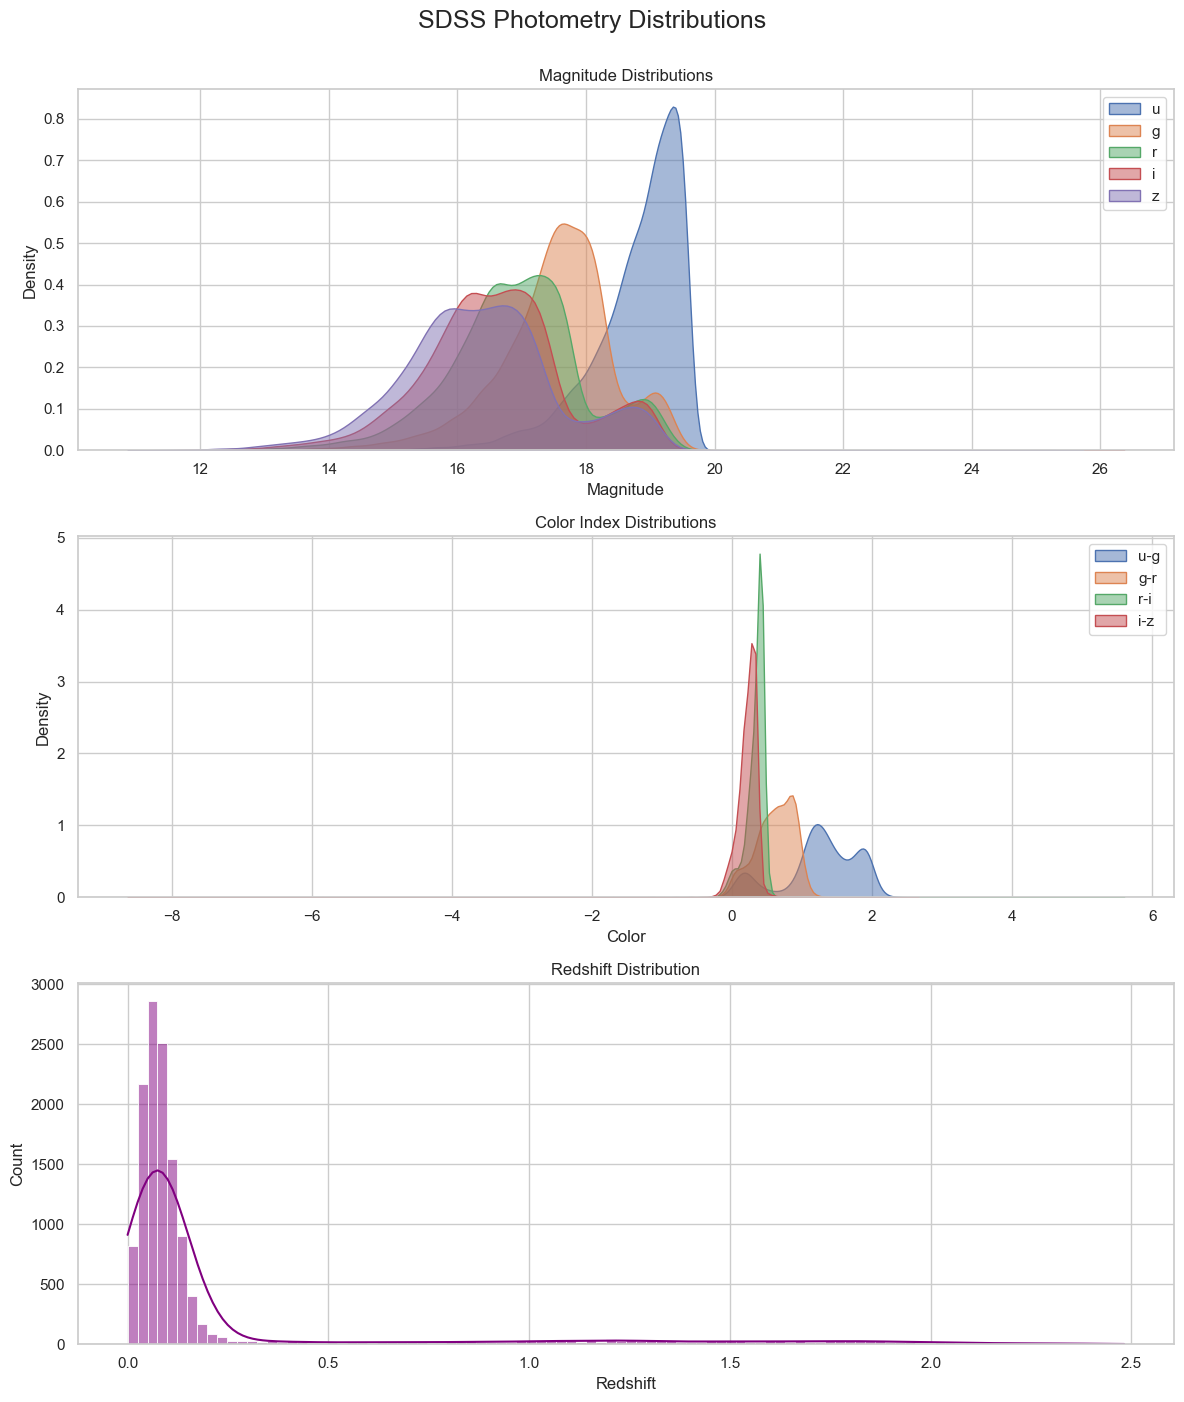

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn theme
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 14))
fig.suptitle('SDSS Photometry Distributions', fontsize=18, y=1)

# 1. Magnitudes
mags = ['u', 'g', 'r', 'i', 'z']
for mag in mags:
    sns.kdeplot(df[mag], label=mag, ax=axes[0], fill=True, alpha=0.5)
axes[0].set_title('Magnitude Distributions')
axes[0].set_xlabel('Magnitude')
axes[0].legend()

# 2. Colors
colors = ['u-g', 'g-r', 'r-i', 'i-z']
for color in colors:
    sns.kdeplot(df[color], label=color, ax=axes[1], fill=True, alpha=0.5)
axes[1].set_title('Color Index Distributions')
axes[1].set_xlabel('Color')
axes[1].legend()

# 3. Redshift
sns.histplot(df['redshift'], bins=100, kde=True, ax=axes[2], color='purple')
axes[2].set_title('Redshift Distribution')
axes[2].set_xlabel('Redshift')

plt.tight_layout()
plt.show()


Now let's define the data into features and target then split the data,

In [48]:
from sklearn.model_selection import train_test_split

# Define feature matrix X and target vector y
features = ['u-g', 'g-r', 'r-i', 'i-z']
target = 'redshift'

X = df[features]
y = df[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (10624, 4)
Test set size: (2657, 4)


Next step is to define the evaluation metrics

## Regression Evaluation

When evaluating the performance of a regression model (such as predicting galaxy redshift from colors), several metrics can be used to quantify the error between predicted and actual values. Below are common metrics used in regression.

---

### 1. **Mean Absolute Error (MAE)**

- **Formula**:  
  $$
  \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|$$

- **Objective**:  
  Measures the average absolute difference between predicted values $(\hat{y}_i)$ and true values $(y_i)$. MAE is simple and interpretable; it tells us, on average, how wrong our predictions are.

---

### 2. **Mean Squared Error (MSE)**

- **Formula**:  
  $$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2$$

- **Objective**:  
  Penalizes larger errors more than MAE by squaring the difference. This makes it sensitive to outliers.

---

### 3. **Root Mean Squared Error (RMSE)**

- **Formula**:  
  $$\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2 }$$

- **Objective**:  
  Provides error in the same units as the target variable (e.g., redshift). Like MSE, it emphasizes larger errors.

---

### 4. **R² Score (Coefficient of Determination)**

- **Formula**:  
  $$
  R^2 = 1 - \frac{\sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2}{\sum_{i=1}^{n} \left( y_i - \bar{y} \right)^2}
  $$
  where \(\bar{y}\) is the mean of the true values.
  
- **Objective**:  
  Indicates how well the model explains the variance in the data.  
  - $(R^2 = 1)$: perfect prediction  
  - $(R^2 = 0)$: model does no better than the mean  
  - $(R^2 < 0)$: model is worse than predicting the mean

---

More info can be found here: <https://scikit-learn.org/0.15/modules/model_evaluation.html#regression-metrics>

In [51]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


# Helper function to evaluate and plot model performance
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{name}")
    print("-" * len(name))
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Predicted vs Actual
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, s=5, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel('True Redshift')
    plt.ylabel('Predicted Redshift')
    plt.title(f'{name} — Predicted vs Actual')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    plt.hist(residuals, bins=50, color='gray', edgecolor='black')
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f'{name} — Residual Distribution')
    plt.xlabel('Residual (y_true - y_pred)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Linear Regression
-----------------
MAE:  0.2350
RMSE: 0.3351
R² Score: 0.4500


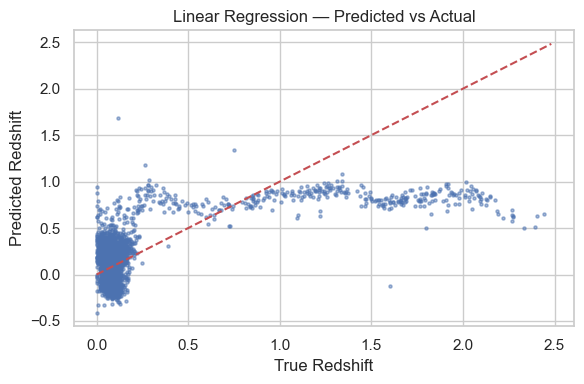

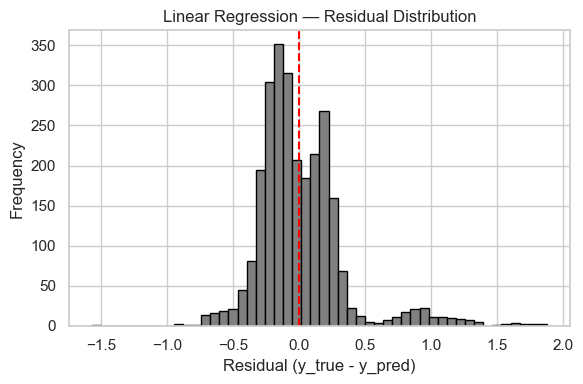


Lasso Regression (L1)
---------------------
MAE:  0.2334
RMSE: 0.3361
R² Score: 0.4468


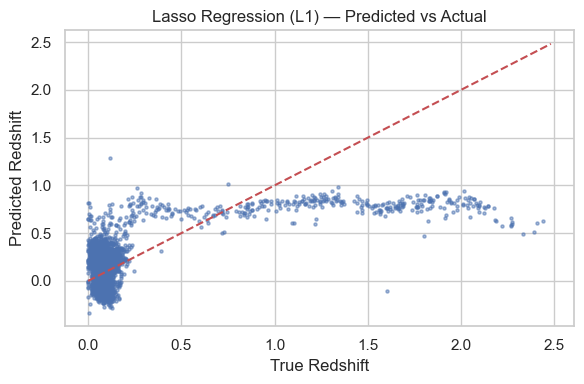

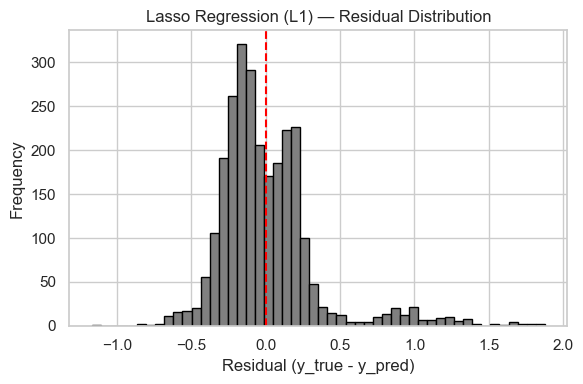


Ridge Regression (L2)
---------------------
MAE:  0.2350
RMSE: 0.3351
R² Score: 0.4500


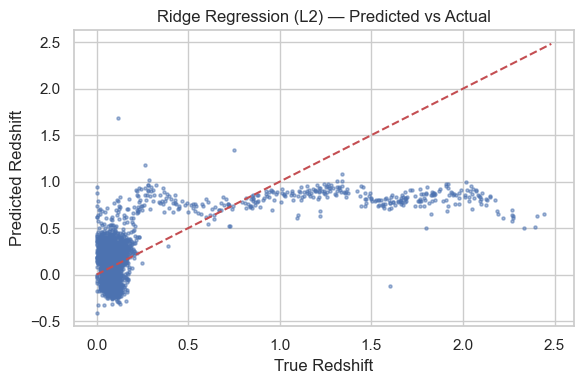

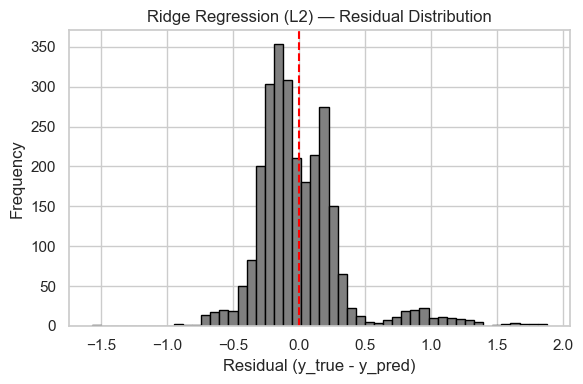


K-Nearest Neighbors (k=5)
-------------------------
MAE:  0.0554
RMSE: 0.1741
R² Score: 0.8515


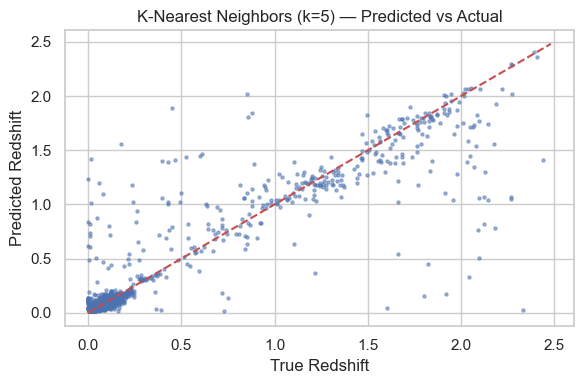

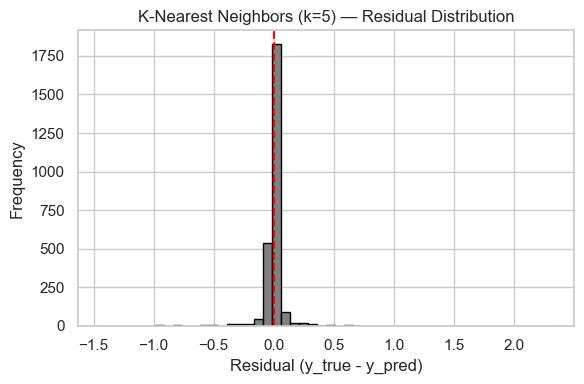


Decision Tree Regressor
-----------------------
MAE:  0.0664
RMSE: 0.2241
R² Score: 0.7540


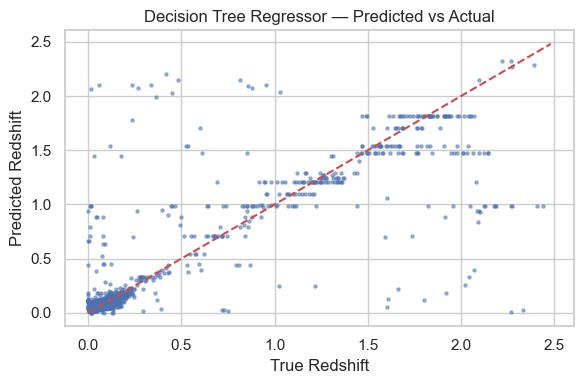

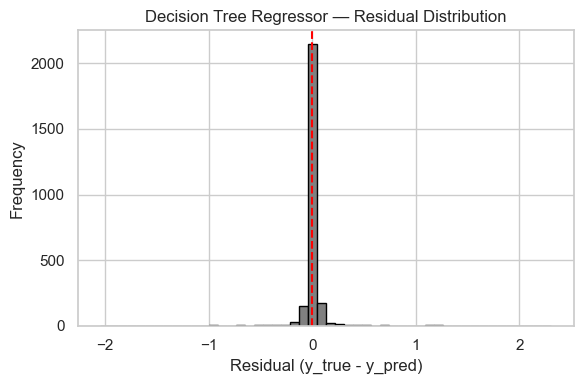


Random Forest Regressor
-----------------------
MAE:  0.0578
RMSE: 0.1787
R² Score: 0.8435


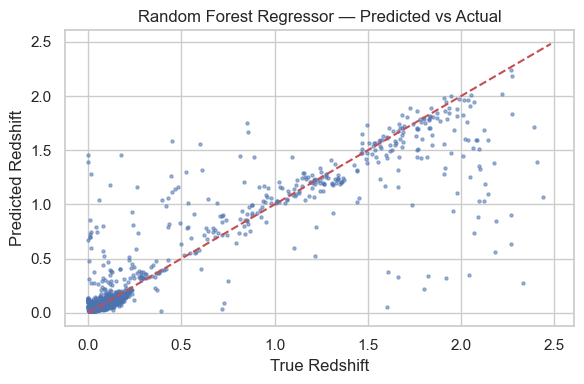

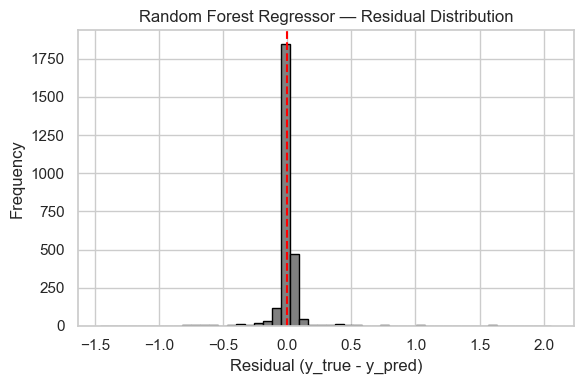


Support Vector Regressor
------------------------
MAE:  0.0724
RMSE: 0.2128
R² Score: 0.7781


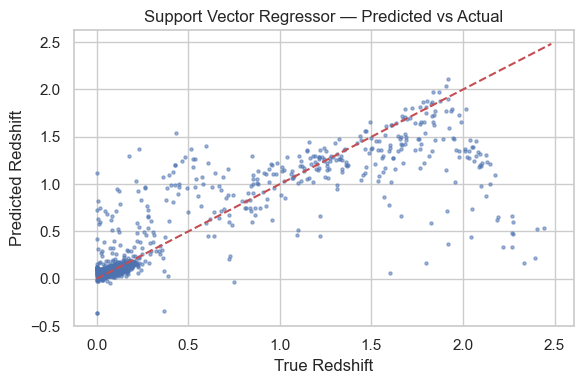

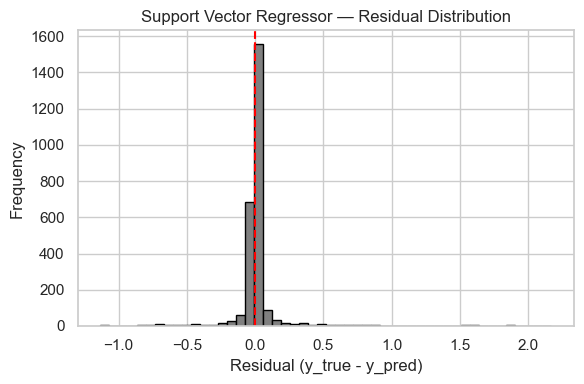

In [53]:
# 1. Linear Regression
evaluate_model(LinearRegression(), "Linear Regression")

# 2. Lasso Regression (L1)
evaluate_model(Lasso(alpha=0.01), "Lasso Regression (L1)")

# 3. Ridge Regression (L2)
evaluate_model(Ridge(alpha=1.0), "Ridge Regression (L2)")

# 4. K-Nearest Neighbors
evaluate_model(KNeighborsRegressor(n_neighbors=5), "K-Nearest Neighbors (k=5)")

# 5. Decision Tree Regressor
evaluate_model(DecisionTreeRegressor(max_depth=10, random_state=42), "Decision Tree Regressor")

# 6. Random Forest Regressor
evaluate_model(RandomForestRegressor(n_estimators=100, random_state=42), "Random Forest Regressor")

# 7. Support Vector Regressor (SVR)
evaluate_model(SVR(kernel='rbf', C=1.0, epsilon=0.01), "Support Vector Regressor")

We can see the Linear Regression models perfomed poorly compared to KNN, SVM, Decision Trees and Random Forest.

## Feature Scaling

Feature scaling is a preprocessing step in many machine learning tasks. It ensures that features contribute equally to the model by transforming them into a comparable scale. This is especially important for algorithms that compute distances or assume normally distributed data.

---

### Why Feature Scaling is Important

Many machine learning algorithms perform better or converge faster when features are on a similar scale. Without scaling:

- Models may become biased toward features with larger magnitudes.
- Optimization algorithms may take longer to converge.
- Models that rely on distances (e.g., k-NN, SVM) may produce suboptimal results.

---

### Common Feature Scaling Techniques

#### 1. **Min-Max Scaling (Normalization)**

**Formula:**

$$
x_{\text{scaled}} = \frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}}
$$

**Range:** $([0, 1])$ or any custom range.

**Use when:**
- You want to preserve the shape of the original distribution.
- The algorithm is sensitive to the scale (e.g., neural networks, k-NN, SVM).

---

#### 2. **Standardization (Z-score Normalization)**

**Formula:**

$$
x_{\text{scaled}} = \frac{x - \mu}{\sigma}
$$

Where:
- $(\mu)$ is the mean of the feature.
- $(\sigma)$ is the standard deviation.

**Range:** Unbounded (mean = 0, standard deviation = 1)

**Use when:**
- Features have Gaussian-like distributions.
- The algorithm assumes normally distributed features (e.g., logistic regression, linear regression, SVM, PCA).

---

#### 3. **Robust Scaling**

**Formula:**

$$
x_{\text{scaled}} = \frac{x - \text{median}(x)}{\text{IQR}(x)}
$$

Where IQR is the interquartile range $(Q_3 - Q_1)$.

**Use when:**
- The dataset contains many outliers.
- You want a robust alternative to standardization.

---

#### 4. **MaxAbs Scaling**

**Formula:**

$$
x_{\text{scaled}} = \frac{x}{\max(|x|)}
$$

**Use when:**
- Features are already centered around zero.
- You want to preserve sparsity in sparse datasets (e.g., text data).

---

### When to Scale Features

Feature scaling is especially important for:

- Distance-based models: k-Nearest Neighbors (k-NN), Support Vector Machines (SVM)
- Regularized models: Ridge, Lasso
- Gradient-based methods: Logistic Regression, Neural Networks
- Dimensionality reduction: PCA, t-SNE

**Not usually required for:**
- Tree-based models: Decision Trees, Random Forests, Gradient Boosted Trees

---
For more on feature scaling, see <https://scikit-learn.org/stable/modules/preprocessing.html>.


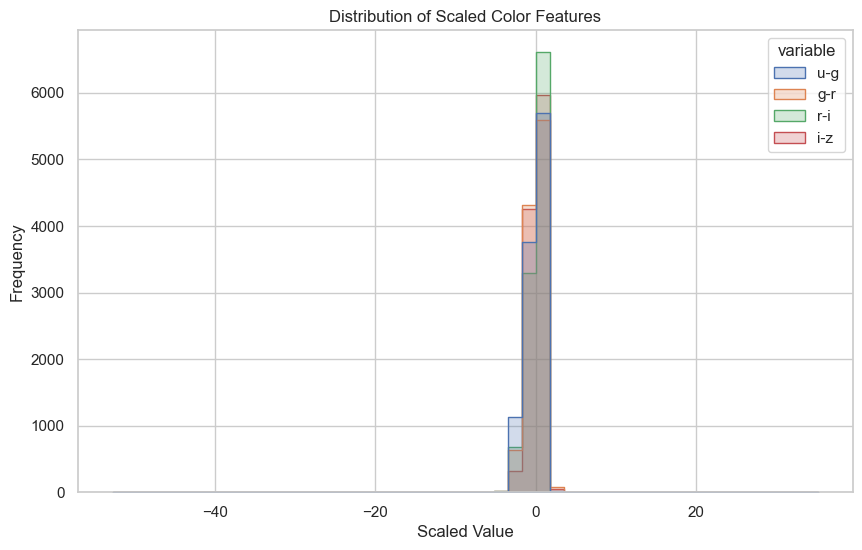

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Plot scaled features distribution
scaled_df = pd.DataFrame(X_train_scaled, columns=['u-g', 'g-r', 'r-i', 'i-z'])
plt.figure(figsize=(10, 6))
sns.histplot(data=scaled_df.melt(), x='value', hue='variable', bins=50, element='step', common_norm=False)
plt.title("Distribution of Scaled Color Features")
plt.xlabel("Scaled Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [59]:
# Evaluation function
def evaluate_model(model, name):
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name}:")
    print(f"  Mean Squared Error: {mse:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print("-" * 40)

# Train models
evaluate_model(LinearRegression(), "Linear Regression")
evaluate_model(Ridge(alpha=1.0, random_state=42), "Ridge Regression (L2)")
evaluate_model(Lasso(alpha=0.01, random_state=42), "Lasso Regression (L1)")
evaluate_model(KNeighborsRegressor(n_neighbors=5,), "K-Nearest Neighbors")
evaluate_model(DecisionTreeRegressor(max_depth=10, random_state=42), "Decision Tree Regressor")
evaluate_model(RandomForestRegressor(n_estimators=100, random_state=42), "Random Forest Regressor")
evaluate_model(SVR(kernel='rbf', C=1.0, epsilon=0.01,), "Support Vector Regressor")

Linear Regression:
  Mean Squared Error: 0.1123
  R² Score: 0.4500
----------------------------------------
Ridge Regression (L2):
  Mean Squared Error: 0.1123
  R² Score: 0.4500
----------------------------------------
Lasso Regression (L1):
  Mean Squared Error: 0.1126
  R² Score: 0.4484
----------------------------------------
K-Nearest Neighbors:
  Mean Squared Error: 0.0326
  R² Score: 0.8403
----------------------------------------
Decision Tree Regressor:
  Mean Squared Error: 0.0502
  R² Score: 0.7540
----------------------------------------
Random Forest Regressor:
  Mean Squared Error: 0.0319
  R² Score: 0.8435
----------------------------------------
Support Vector Regressor:
  Mean Squared Error: 0.0367
  R² Score: 0.8201
----------------------------------------


By standard scalimg the galaxy colors, we noticed an improvement with Support Vector Regressor. However, there is no improvement for the other models.

In the next notebook, we will talk about tuning a model to improve the model prediction capabilities.

## Summary
In this notebook, we introduce a simple astronomy dataset application for machine learning. You performed series of regression algorithms and evaluated your model performance on unseen dataset.

## Additional Resources

Intro to machine learning: <https://www.kaggle.com/learn/intro-to-machine-learning>

Google Machine Learning Crash Course: <https://developers.google.com/machine-learning/crash-course>

Regression Evaluation Metrics: <https://www.kaggle.com/code/marcinrutecki/regression-models-evaluation-metrics>